In [1]:
# Setup (PyTorch, paths, device, seeds)
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms ,models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tempfile

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(42)

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [4]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

print("Train dir contents:", os.listdir(train_dir))
print("Val dir contents:", os.listdir(val_dir))
print("Test dir contents:", os.listdir(test_dir))

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir contents: ['PNEUMONIA', 'NORMAL']


In [5]:
def plot_distribution_from_folder(base_dir, splits, class_names, title_prefix):
    for split in splits:
        counts = []
        for cls in class_names:
            folder = os.path.join(base_dir, split, cls)
            counts.append(len(os.listdir(folder)))
        plt.figure(figsize=(6,4))
        plt.bar(class_names, counts)
        plt.title(f"{title_prefix} {split} set class counts")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


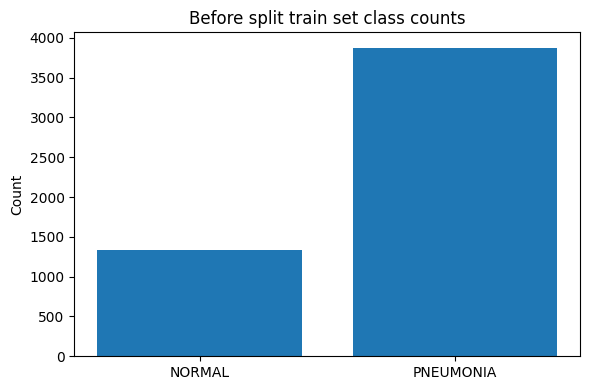

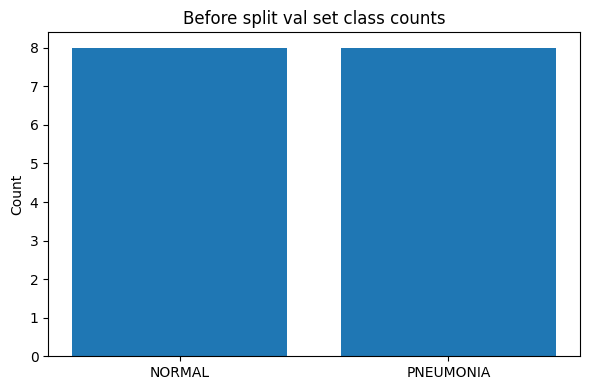

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


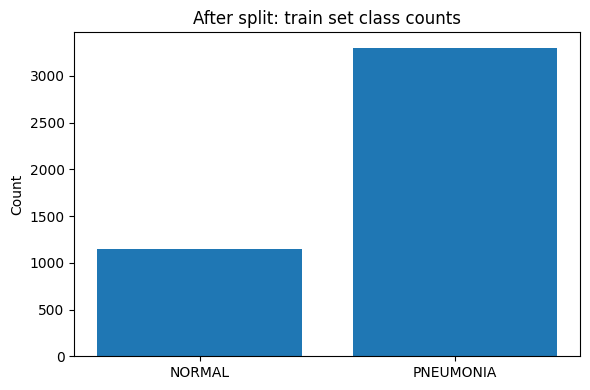

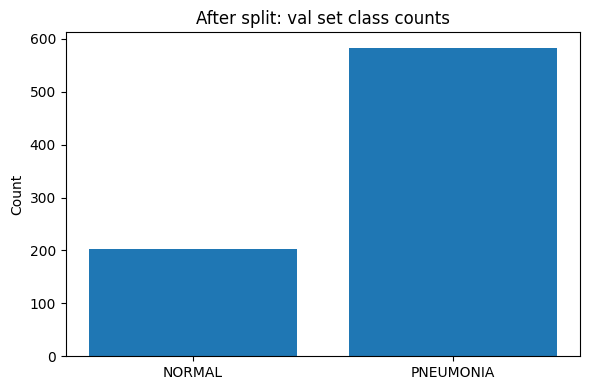

In [6]:
# Print image counts before shuffle/split
print('Before split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

class_names = ['NORMAL', 'PNEUMONIA']
plot_distribution_from_folder(base_dir, ['train', 'val'], class_names, "Before split")

# Combine all images from train and val only (do not touch test)
all_data = []
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        for fname in os.listdir(folder):
            all_data.append((os.path.join(folder, fname), cls))

# Stratified split: 85% train, 15% val
paths, labels = zip(*all_data)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.15, stratify=labels, random_state=42)

def copy_files(file_paths, labels, dest_dir):
    for path, label in zip(file_paths, labels):
        dest = os.path.join(dest_dir, label)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(path, dest)

# Set your new base_dir for split (must be writable, e.g., /kaggle/working or local path)
# Use /kaggle/working if running on Kaggle, or a local writable path otherwise

# Use a writable temp directory for the split
new_base = os.path.join(tempfile.gettempdir(), "chest_xray_split")
copy_files(train_paths, train_labels, os.path.join(new_base, 'train'))
copy_files(val_paths, val_labels, os.path.join(new_base, 'val'))

# Print image counts after shuffle/split
print('After split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

# Plot distribution after split
plot_distribution_from_folder(new_base, ['train', 'val'], class_names, "After split:")

# Update directory variables to point to the new split
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')
# test_dir remains unchanged

In [7]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    normalize,
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

Classes: ['NORMAL', 'PNEUMONIA'] => {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
# CNN model as a class (__init__ + forward)
class PneumoCNN(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(PneumoCNN, self).__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(m.fc.in_features, 1)
        )
        self.net = m

    def forward(self, x):
        return self.net(x).squeeze(1)  # [B]

In [9]:
model = PneumoCNN()
model

PneumoCNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = int(EPOCHS * 2/3)
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device:  cuda


In [11]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
train_targets = torch.tensor([y for _, y in train_ds.samples])
pos = (train_targets==1).sum().item()
neg = (train_targets==0).sum().item()
pos_weight = torch.tensor([neg / max(pos,1.0)], dtype=torch.float32)
print(f"Train counts -> NEG(NORMAL)={neg}, POS(PNEUMONIA)={pos}, pos_weight={pos_weight.item():.3f}")

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


In [12]:
# # Loss, Optimizer, LR scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # robust for class imbalance
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Utilities: train/eval loops
def accuracy_from_logits(logits, targets):
    probs = torch.sigmoid(logits).squeeze(1)
    preds = (probs >= 0.5).long()
    correct = (preds == targets.long()).sum().item()
    return correct, preds, probs

def run_one_epoch(model, loader, epochNumber, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    epoch_loss = 0.0
    correct = 0
    n = 0
    all_probs, all_targets = [], []

    for images, targets in tqdm(loader, desc=f"Epoch {epochNumber}/{EPOCHS}"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits  = model(images)
            if logits.ndim == 2 and logits.size(1) == 1:
                logits = logits[:, 0]
            targets = targets.float().view(-1)
            loss = criterion(logits, targets)
            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        c, _, probs = accuracy_from_logits(logits.unsqueeze(1), targets)
        epoch_loss += loss.item() * images.size(0)
        correct += c
        n += images.size(0)

        all_probs.append(probs.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = epoch_loss / n
    acc = correct / n
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Some environments may lack enough positive/negative samples for AUC early on; guard it
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float('nan')

    return avg_loss, acc, auc, all_probs, all_targets

In [14]:
# CTraining over epochs with early stopping + checkpoint
# best_val_acc = -np.inf
best_val_auc = -np.inf
no_improve = 0
ckpt_path = "best_cnn_pneumonia.pt"

history = {"train_loss":[], "train_acc":[], "train_auc":[],
           "val_loss":[], "val_acc":[], "val_auc":[]}

start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_auc, _, _ = run_one_epoch(model, train_loader, epoch, optimizer)
    val_loss, val_acc, val_auc, _, _ = run_one_epoch(model, val_loader, epoch, optimizer=None)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_auc"].append(tr_auc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc);   history["val_auc"].append(val_auc)

    scheduler.step(val_auc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | "
          f"Val: loss {val_loss:.4f} acc {val_acc:.4f} auc {val_auc:.4f}")

    # Early stopping & checkpoint
    # if va_acc > best_val_acc:
    #     best_val_acc = va_acc
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch}, ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val AUC: {best_val_auc:.4f}")


# print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

Epoch 1/15: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 01/15 | Train: loss 0.0874 acc 0.9283 auc 0.9829 | Val:   loss 0.0463 acc 0.9554 auc 0.9958


Epoch 2/15: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


Epoch 02/15 | Train: loss 0.0507 acc 0.9600 auc 0.9938 | Val:   loss 0.0511 acc 0.9490 auc 0.9958


Epoch 3/15: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 03/15 | Train: loss 0.0505 acc 0.9606 auc 0.9939 | Val:   loss 0.0999 acc 0.9006 auc 0.9966


Epoch 4/15: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


Epoch 04/15 | Train: loss 0.0389 acc 0.9690 auc 0.9963 | Val:   loss 0.1256 acc 0.9516 auc 0.9959


Epoch 5/15: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 05/15 | Train: loss 0.0467 acc 0.9669 auc 0.9943 | Val:   loss 0.0386 acc 0.9745 auc 0.9973


Epoch 6/15: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 06/15 | Train: loss 0.0339 acc 0.9739 auc 0.9972 | Val:   loss 0.0435 acc 0.9745 auc 0.9961


Epoch 7/15: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 07/15 | Train: loss 0.0404 acc 0.9708 auc 0.9960 | Val:   loss 0.1145 acc 0.9618 auc 0.9960


Epoch 8/15: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


Epoch 08/15 | Train: loss 0.0282 acc 0.9798 auc 0.9980 | Val:   loss 0.2577 acc 0.9223 auc 0.9952


Epoch 9/15: 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


Epoch 09/15 | Train: loss 0.0215 acc 0.9849 auc 0.9987 | Val:   loss 0.0624 acc 0.9783 auc 0.9985


Epoch 10/15: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 10/15 | Train: loss 0.0210 acc 0.9827 auc 0.9988 | Val:   loss 0.2808 acc 0.8994 auc 0.9975


Epoch 11/15: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 11/15 | Train: loss 0.0185 acc 0.9861 auc 0.9990 | Val:   loss 0.1178 acc 0.9592 auc 0.9984


Epoch 12/15: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 12/15 | Train: loss 0.0191 acc 0.9865 auc 0.9990 | Val:   loss 0.0292 acc 0.9796 auc 0.9983


Epoch 13/15: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 13/15 | Train: loss 0.0132 acc 0.9885 auc 0.9996 | Val:   loss 0.0955 acc 0.9618 auc 0.9981


Epoch 14/15: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 14/15 | Train: loss 0.0116 acc 0.9917 auc 0.9997 | Val:   loss 0.0497 acc 0.9771 auc 0.9990


Epoch 15/15: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]

Epoch 15/15 | Train: loss 0.0136 acc 0.9888 auc 0.9995 | Val:   loss 0.1344 acc 0.9490 auc 0.9983
Training finished in 34.9 min. Best val AUC: 0.9990


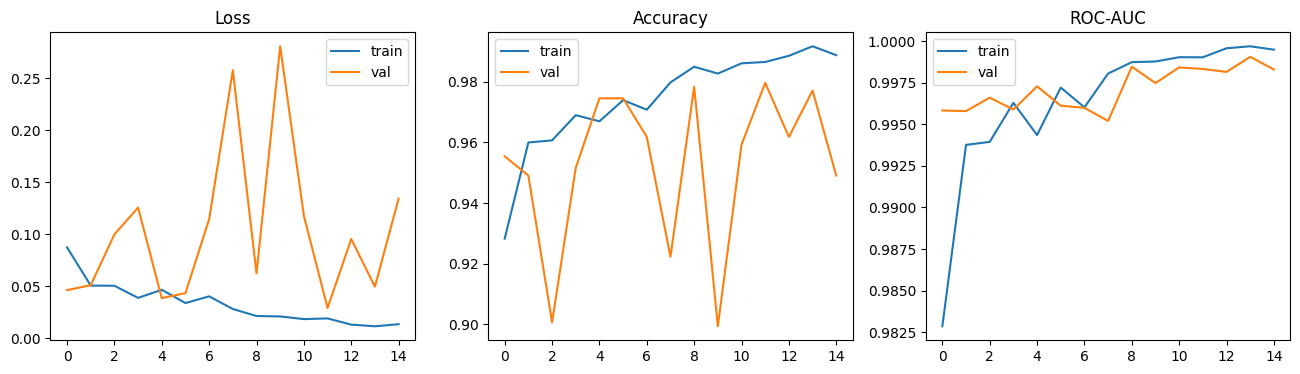

In [15]:
# Load best checkpoint (optional) and plot curves
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

def plot_curves(h):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].plot(h["train_loss"], label="train"); axs[0].plot(h["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()
    axs[1].plot(h["train_acc"], label="train"); axs[1].plot(h["val_acc"], label="val")
    axs[1].set_title("Accuracy"); axs[1].legend()
    axs[2].plot(h["train_auc"], label="train"); axs[2].plot(h["val_auc"], label="val")
    axs[2].set_title("ROC-AUC"); axs[2].legend()
    plt.show()

plot_curves(history)

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve

# Get validation scores (probabilities for Pneumonia=1) and labels
_, _, va_auc, va_probs, va_targets = run_one_epoch(model, val_loader, 0, optimizer=None)

# Max F1
prec, rec, thr_pr = precision_recall_curve(va_targets, va_probs)  # thr_pr length = len(prec)-1
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
thr_f1 = float(thr_pr[f1.argmax()])

best_thr = thr_f1   # or thr_j
print("Chosen threshold:", best_thr)

Epoch 0/15: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]

Chosen threshold: 0.9280354380607605


Epoch 1/15: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


TEST — loss: 1.0891 | acc@thr: 0.8381 | auc: 0.9711
Confusion Matrix:
 [[134 100]
 [  1 389]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9926    0.5726    0.7263       234
   PNEUMONIA     0.7955    0.9974    0.8851       390

    accuracy                         0.8381       624
   macro avg     0.8940    0.7850    0.8057       624
weighted avg     0.8694    0.8381    0.8255       624



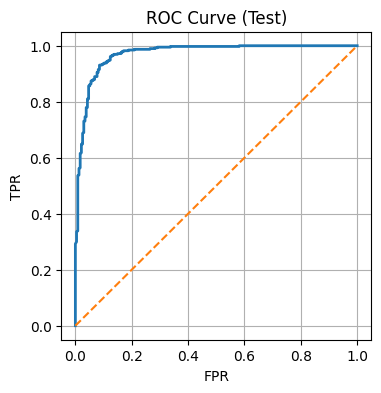

In [18]:
# Final test evaluation + confusion matrix, precision/recall/F1
test_loss, _, test_auc, test_probs, targets = run_one_epoch(model, test_loader, 1, optimizer=None)
test_preds = (test_probs >= best_thr).astype(int)
test_acc_thr = (test_preds == targets).mean()

# print(f"test pres (first 10): {probs[:10]}")
# ## consider using a threshold other than 0.5
# preds = (probs >= 0.5).astype(int)

print(f"TEST — loss: {test_loss:.4f} | acc@thr: {test_acc_thr:.4f} | auc: {test_auc:.4f}")

cm = confusion_matrix(targets, test_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(targets, test_preds, target_names=test_ds.classes, digits=4))

# Quick ROC curve
fpr, tpr, _ = roc_curve(targets, test_probs)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)')
plt.grid(True); plt.show()

In [ ]:
# Inference helper (predict on a few samples)
from PIL import Image

def predict_image(path, model, tfms=eval_tfms):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= best_thr)
    return prob, pred  # probability of PNEUMONIA, predicted label (0 normal / 1 pneumonia)

# Example:
# p, yhat = predict_image(os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir,"PNEUMONIA"))[0]), model)
# print(p, yhat)


In [ ]:
# TODO: consider adding Visualizations like the R3